# Observational overview figure


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import utils
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker


from scipy.io import savemat

Load required data.

In [2]:
AS = xr.open_dataset("../data/ABLE_sentinel_mooring_2018.nc")
DD = xr.open_dataset("../data/downstream_deep_mooring_2018.nc")
bathy = xr.open_dataset("../data/bathy_sep_2018.nc")

# Create some kind of depth variable...
AS["depth_adcp"] = AS.depth_ADCP.mean().values - AS.distance

# Simple map

/Users/jmcusack/miniconda3/envs/lciw/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/jmcusack/miniconda3/envs/lciw/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


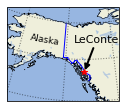

In [3]:
lon0 = AS.lon.values
lat0 = AS.lat.values

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=lon0, central_latitude=lat0,))
ax.set_extent([-160, -120, 50, 73], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE, lw=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', color="b")
ax.add_feature(cfeature.LAKES, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', draw_labels=False, alpha=0.5, linestyle=':')
gl.xlocator = mticker.FixedLocator([-180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([50, 60, 70])

ax.plot(lon0, lat0, 'r*', transform=ccrs.PlateCarree())

arrowprops=dict(arrowstyle= '-|>', color='k', lw=2, ls='-')
ax.annotate("LeConte", (lon0, lat0), (-10, 30), textcoords="offset points", transform=ccrs.PlateCarree(), arrowprops=arrowprops, fontsize=11)
ax.annotate("Alaska", (0.2, 0.6), xycoords="axes fraction", fontsize=9, rotation=-10)

fig.savefig("../figures/simple_map.pdf", dpi=300, bbox_inches="tight", pad_inches=0)
fig.savefig("../figures/simple_map.png", dpi=300, bbox_inches="tight", pad_inches=0)

# Save for matlab plotting...

In [4]:
bathy_ = bathy.H.sel(lon=slice(-132.365, -132.3545), lat=slice(56.834, 56.840))
bathy_dict = dict(H=bathy_.values, x=bathy_.x.values, y=bathy_.y.values)
savemat("../data/bathy.mat", bathy_dict)

In [5]:
DD_ = DD.isel(depth_adcp = (DD.depth_adcp > 10) & (DD.depth_adcp < 150)).mean("time")
AS_ = AS.isel(distance = (AS.depth_adcp > 10) & (AS.depth_adcp < 150)).mean("time")

onesMD = np.ones_like(DD_.u)
onesMN = np.ones_like(AS_.u)

MD_dict = dict(x=DD_.x.values*onesMD, y=DD_.y.values*onesMD, z=-DD_.depth_adcp.values, u=DD_.u.values, v=DD_.v.values, w=0*onesMD)
savemat("../data/MD.mat", MD_dict)

MN_dict = dict(x=AS_.x.values*onesMN, y=AS_.y.values*onesMN, z=-AS_.depth_adcp.values, u=AS_.u.values, v=AS_.v.values, w=0*onesMN)
savemat("../data/MN.mat", MN_dict)

# Cartopy and openstreetmap

In [6]:
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
from scalebar import scale_bar
from matplotlib import patheffects


def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [7]:
cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

Make the plot

/Users/jmcusack/miniconda3/envs/lciw/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:845: UserWarning: Approximating coordinate system <Derived Geographic 2D CRS: GEOGCRS["unnamed",BASEGEOGCRS["unknown",DATUM["unk ...>
Name: unnamed
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: PROJ ob_tran o_proj=latlon
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


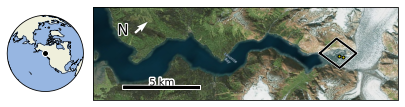

In [8]:
scale = 12

proj = ccrs.RotatedPole(pole_longitude=120, pole_latitude=55)

fig = plt.figure(figsize=(7, 4)) 

gs = plt.GridSpec(1, 2, width_ratios=[1, 4], wspace=0.05)
ax = plt.subplot(gs[1], projection=proj) # project using coordinate reference system (CRS) of street map
ax1 = plt.subplot(gs[0], projection=ccrs.Orthographic(AS.lon.values, AS.lat.values))

# The global map
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE, lw=0.5)
ax1.plot(AS.lon.values, AS.lat.values, 'ko', transform=ccrs.PlateCarree(), ms=6, markeredgecolor="w")
ax1.set_global()

# Add the open street map view of the glacier
ax.set_extent([-40.43, -40.20, 36.17, 36.24], crs=proj) # set extents in weird rotated coordinates
ax.add_image(img, int(scale))
ax.set_aspect(1.2) 

# Mooring locations
ax.plot(AS.lon, AS.lat, 'yo', ms=3, transform=ccrs.PlateCarree(), markeredgecolor="k")
ax.plot(DD.lon, DD.lat, 'yo', ms=3, transform=ccrs.PlateCarree(), markeredgecolor="k")


# North arrow
Nlon = -132.55
Nlat = 56.765

buffer = [patheffects.withStroke(linewidth=2, foreground="w")]
ax.quiver(np.array([Nlon]), np.array([Nlat]), np.array([0]), np.array([10]), transform=ccrs.PlateCarree(), color="w")
ax.annotate("N", (0.08, 0.7), xycoords="axes fraction", fontsize=15, color="k", path_effects=buffer)


# Box around study region
lllon = -132.38
lllat = 56.83
urlon = -132.35
urlat = 56.845
buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
ax.plot([lllon, urlon, urlon, lllon, lllon], [lllat, lllat, urlat, urlat, lllat], transform=ccrs.PlateCarree(), lw=2, color="k", path_effects=buffer)

# Scale bar! (quirky)
scale_bar(ax, proj, 5, location=(0.4, 0.2), rotate=44.5)


fig.savefig("../figures/complex_map.pdf", dpi=300, bbox_inches="tight", pad_inches=0)
fig.savefig("../figures/complex_map.png", dpi=300, bbox_inches="tight", pad_inches=0)

# Mooring diagrams

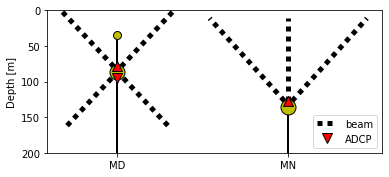

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_ylim(200, 0)
ax.set_aspect("equal")
ax.set_xticks([])

MN = AS
MD = DD

# MN
xMN = +120

# ax.fill_betweenx(MN.depth, xMN - np.cos(np.deg2rad(MN.beamAngle))*MN.distance, xMN + np.cos(np.deg2rad(MN.beamAngle))*MN.distance, color="gray")
ax.plot(xMN - np.cos(np.deg2rad(MN.beamAngle))*MN.distance, MN.depth, color="k", ls=(0, (1, 1)), lw=5)
ax.plot(xMN + np.cos(np.deg2rad(MN.beamAngle))*MN.distance, MN.depth, color="k", ls=(0, (1, 1)), lw=5)
ax.plot(np.full_like(MN.depth, xMN), MN.depth, color="k", ls=(0, (1, 1)), lw=5)
ax.plot([xMN, xMN], [200, MN.depth[0]], 'k', lw=2)
ax.plot(xMN, MN.depth[0] + 8, marker="o", ms=15, ls="", color="y", markeredgecolor="k")
ax.plot(xMN, MN.depth[0], marker="^", ms=10, ls="", color="r", markeredgecolor="k")

# MD
xMD = -120
beam_angle = 20

ax.plot(xMD - np.cos(np.deg2rad(beam_angle))*MD.distance, MD.depth_adcp, color="k", lw=5, ls=(0, (1, 1)), label="beam")
ax.plot(xMD + np.cos(np.deg2rad(beam_angle))*MD.distance, MD.depth_adcp, color="k", lw=5, ls=(0, (1, 1)))
ax.plot([xMD, xMD], [200, MD.depth_instrument[0]], 'k', lw=2)
ax.plot(xMD, MD.depth_instrument[0], marker="o", ms=8, ls="", color="y", markeredgecolor="k")
ax.plot(xMD, MD.depth_instrument[2], marker="o", ms=15, ls="", color="y", markeredgecolor="k")
ax.plot(xMD, MD.depth_instrument[2] - 8, marker="^", ms=10, ls="", color="r", markeredgecolor="k")
ax.plot(xMD, MD.depth_instrument[3] + 8, marker="v", ms=10, ls="", color="r", markeredgecolor="k", label="ADCP")
# ax.fill_betweenx(MD.depth_adcp, xMD - np.cos(np.deg2rad(beam_angle))*MD.distance, xMD + np.cos(np.deg2rad(beam_angle))*MD.distance, color="gray")

ax.set_xticks([xMN, xMD])
ax.set_xticklabels(["MN", "MD"])
ax.set_ylabel("Depth [m]")

ax.legend()

fig.savefig("../figures/mooring_diagrams.pdf", dpi=600, bbox_inches="tight", pad_inches=0.01)
fig.savefig("../figures/mooring_diagrams.png", dpi=600, bbox_inches="tight", pad_inches=0.01)